## Connect drive with colab

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import os
Root = "/content/drive/MyDrive/Deepranjan/DL-Projects/Image-to-text/Captcha"
os.chdir(Root)

# Imports

In [ ]:
import os

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL import Image

import numpy as np
import pickle as pkl
import matplotlib.pyplot as plt

# Custom Dataset Preparation

In [ ]:
class Dataset(Dataset):

    def __init__(self, img_dir):
        path_list = os.listdir(img_dir)
        abspath = os.path.abspath(img_dir)

        self.img_list = [os.path.join(abspath, path) for path in path_list]

        self.transform = transforms.Compose([
            # transforms.RandomRotation(degrees=90, expand=True),
            transforms.ToTensor(),

        ])
        

    def __len__(self):
        return len(self.img_list)
    
    
    def __getitem__(self, idx):
        path = self.img_list[idx]

        label = os.path.basename(path).split('.')[0].lower().strip()
        img = Image.open(path).convert('RGB').resize((200,50))

        img_tensor = self.transform(img)
        return img_tensor, label

# CRNN Class

In [ ]:
class CRNN(nn.Module):

    def __init__(self, vocab_size, dropout=0.5):
        super(CRNN, self).__init__()

        self.dropout = nn.Dropout(dropout)

        self.convlayer = nn.Sequential(
            nn.Conv2d(3, 32, (3,3), stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d((2,2), 2),

            nn.Conv2d(32, 64, (3,3), stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d((2,2), 2),

            nn.Conv2d(64, 128, (3,3), stride=1, padding=1),
            nn.ReLU(),

            nn.Conv2d(128, 256, (3,3), stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d((1,2), 2),

            nn.Conv2d(256, 512, (3,3), stride=1, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(),

            nn.Conv2d(512, 512, (3,3), stride=1, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.MaxPool2d((1,2), 2),

            nn.Conv2d(512, 512, (2,2), stride=1, padding=0),
            self.dropout
        )

        self.mapSeq = nn.Sequential(
            nn.Linear(1024, 256),
            # nn.Linear(15872, 256),
            self.dropout
        )
        
        self.lstm_0 = nn.GRU(256, 256, bidirectional=True)  
        self.lstm_1 = nn.GRU(512, 256, bidirectional=True)

        self.out = nn.Sequential(
            nn.Linear(512, vocab_size),
        )
        
        
    def forward(self, x): 
        x = self.convlayer(x)

        x = x.permute(0, 3, 1, 2)
        x = x.view(x.size(0), x.size(1), -1)
     
        x = self.mapSeq(x)

        x, _ = self.lstm_0(x)
        x, _ = self.lstm_1(x)

        x = self.out(x)   
        return x.permute(1, 0, 2)

# OCR Class

In [ ]:
class OCR:
    
    def __init__(self):
        self.device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

        self.crnn = CRNN(VOCAB_SIZE).to(self.device)
        print('Model loaded to ', self.device)

        self.critertion = nn.CTCLoss(blank=0)

        self.char2idx, self.idx2char = self.char_idx()


    def char_idx(self):
        char2idx = {}
        idx2char = {}

        characters = CHARS.lower() + '-'
        for i, char in enumerate(characters):
            char2idx[char] = i + 1
            idx2char[i + 1] = char

        return char2idx, idx2char
        

    def encode(self, labels):
        length_per_label = [len(label) for label in labels]
        joined_label = ''.join(labels)

        joined_encoding = []
        for char in joined_label:
           joined_encoding.append(self.char2idx[char]) 

        return (torch.IntTensor(joined_encoding), torch.IntTensor(length_per_label) )


    def decode(self, logits):
        tokens = logits.softmax(2).argmax(2).squeeze(1)
        
        tokens = ''.join([self.idx2char[token] 
                        if token != 0  else '-' 
                        for token in tokens.numpy()])
        tokens = tokens.split('-')
        
        text = [char 
                for batch_token in tokens 
                for idx, char in enumerate(batch_token)
                if char != batch_token[idx-1] or len(batch_token) == 1]
        text = ''.join(text)
        
        return text
        

    def calculate_loss(self, logits, labels):
        encoded_labels, labels_len = self.encode(labels)

        logits_lens = torch.full(
            size=(logits.size(1),), 
            fill_value=logits.size(0), 
            dtype=torch.int32
        ).to(self.device)

        return self.critertion(
            logits.log_softmax(2), encoded_labels, 
            logits_lens, labels_len
        )


    def train_step(self, optimizer, images, labels):
        logits = self.predict(images)

        optimizer.zero_grad()
        loss = self.calculate_loss(logits, labels)
        loss.backward()
        optimizer.step()

        return logits, loss

    
    def val_step(self, images, labels):
        logits = self.predict(images)
        loss = self.calculate_loss(logits, labels)

        return logits, loss


    def predict(self, img):
        return self.crnn(img.to(self.device))


    def train(self, num_epochs, optimizer, train_loader, val_loader, device, print_every=2):
        train_losses, valid_losses = [], []
        self.crnn.to(device)

        for epoch in range(num_epochs):

            tot_train_loss = 0
            self.crnn.train()
            for i, (images, labels) in enumerate(train_loader):
                logits, train_loss = self.train_step(optimizer, images, labels)
                
                tot_train_loss += train_loss.item()

            with torch.no_grad():

                tot_val_loss = 0
                self.crnn.eval()
                for i, (images, labels) in enumerate(val_loader):
                    logits, val_loss = self.val_step(images, labels)

                    tot_val_loss += val_loss.item()
                
                train_loss = tot_train_loss / len(train_loader.dataset)
                val_loss = tot_val_loss / len(val_loader.dataset)

                train_losses.append(train_loss)
                valid_losses.append(val_loss)

            if epoch % print_every == 0:
                print('Epoch [{:5d}/{:5d}] | train loss {:6.4f} | val loss {:6.4f}'.format(
                    epoch+1,
                    num_epochs,
                    train_loss,
                    val_loss
                )) 

        return train_losses, valid_losses

# Train CRNN

In [ ]:
TRAIN_DIR = '/content/drive/MyDrive/Deepranjan/DL-Projects/Image-to-text/custom_data/test'
VAL_DIR = '/content/drive/MyDrive/Deepranjan/DL-Projects/Image-to-text/custom_data/valid'

BATCH_SIZE = 8
N_WORKERS = 2

# CHARS = 'abcdefghijklmnopqrstuvwxyz0123456789'
CHARS = '0123456789ABCDEFGHIJKLMNOPQRSTUVWXYZ '
VOCAB_SIZE = len(CHARS) + 1

lr = 0.001
weight_decay = 1e-5
momentum = 0.7

EPOCHS = 100

In [ ]:
# Dataset
train_dataset = Dataset(TRAIN_DIR)
val_dataset = Dataset(VAL_DIR)

train_loader = DataLoader(
    train_dataset, batch_size=BATCH_SIZE, 
    num_workers=N_WORKERS, shuffle=True
)
val_loader = DataLoader(
    val_dataset, batch_size=BATCH_SIZE, 
    num_workers=N_WORKERS, shuffle=False
)

device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
# Model
ocr = OCR()

# Optimizer | Paper used Adadelta
# optimizer = optim.Adam(ocr.crnn.parameters(), lr = lr,
#                        weight_decay=weight_decay)

optimizer = optim.SGD(
    ocr.crnn.parameters(), lr=lr, nesterov=True,
    weight_decay=weight_decay, momentum=momentum
)


# train
train_losses, val_losses = ocr.train(EPOCHS, optimizer, train_loader, val_loader, device, print_every=1)

Model loaded to  cuda
Epoch [    1/  100] | train loss    nan | val loss    nan
Epoch [    2/  100] | train loss    nan | val loss    nan
Epoch [    3/  100] | train loss    nan | val loss    nan
Epoch [    4/  100] | train loss    nan | val loss    nan
Epoch [    5/  100] | train loss    nan | val loss    nan


KeyboardInterrupt: ignored

# Results

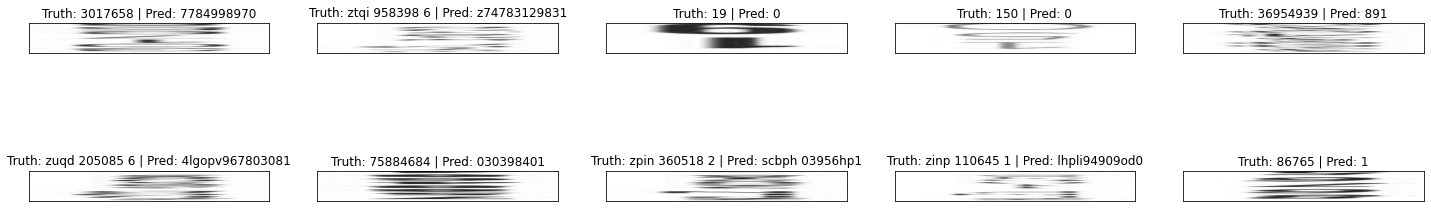

In [ ]:
# view samples
sample_result = []

for i in range(10):
    idx = np.random.randint(len(val_dataset))
    img, label = val_dataset[idx]
    logits = ocr.predict(img.unsqueeze(0))
    pred_text = ocr.decode(logits.cpu())

    sample_result.append( (img, label, pred_text) )

fig = plt.figure(figsize=(25, 5))
for i in range(10):
    ax = fig.add_subplot(2, 5, i+1, xticks=[], yticks=[])

    img, label, pred_text = sample_result[i]
    title = f'Truth: {label} | Pred: {pred_text}'

    ax.imshow(img.permute(1, 2, 0))
    ax.set_title(title)

plt.show() 

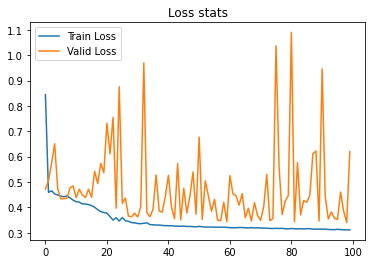

In [ ]:
# plot loss stats
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Valid Loss')
plt.title('Loss stats')
plt.legend()
plt.show()